In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
from ta.momentum import rsi
from ta.trend import macd

# Data collection and preprocessing
The first step of the project is to collect the S&P100 stocks and their historical values. The S&P100 is a stock market index made up of 100 major companies in the United States that are listed on the NYSE or NASDAQ. The index is a subset of the S&P 500 and is used as a benchmark for the US stock market.
The data is first collected then normalized.

## S&P100 stocks
The Wikipedia page is used to retrieve the S&P100 stocks list.
Notes:
- Alphabet Inc. (Google) is listed twice in the table due to the two different classes of shares. GOOGL is kept, as the oldest class of shares, and GOOG is deleted.
- Berkshire Hathaway is listed as BRK-B on wikipedia, while being listed as BRK.B on yahoo! finance. The symbol is changed in this list to the yfinance value.

In [2]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology


## Fundamentals
The fundamentals of the stocks, such as market capitalization or P/E Ratio, are collected via yfinance. These values will be used to find similarities between stock to create the graph.

In [3]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "pegRatio", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
AAPL,2826227941376,28.664076,25.457182,2.52,38.104200,6.43,7.24,4.837,0.1493,1.264,0.73,0.051741,64405549,7.441,0.26306
ABBV,283281752064,47.886720,13.290846,2.34,35.373870,3.35,12.07,4.535,1.7827,0.593,4.40,0.094549,5727850,6.243,0.11016
ABT,182087057408,32.607475,20.363813,2.83,4.691828,3.21,5.14,22.309,0.6480,0.751,1.60,-0.046433,5602221,4.733,0.13961
ACN,191938396160,27.652174,23.268293,3.39,7.077807,11.04,13.12,43.132,0.4370,1.207,1.34,0.145885,2697901,3.020,0.10889
ADBE,216264163328,46.018353,23.698208,2.03,14.144765,10.49,20.37,34.128,0.0000,1.281,0.12,0.428948,3814863,10.831,0.24082


In [4]:
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
AAPL,4.713259,-0.084433,0.860486,0.245153,0.496340,-0.198496,-0.294148,-0.100836,-0.469904,0.740955,-0.958954,-0.493373,3.233542,0.509603,0.738609
ABBV,-0.071343,0.497106,-0.597637,0.187740,0.438498,-0.404537,-0.072273,-0.100843,1.189561,-0.964698,1.212553,-0.372227,-0.368556,0.282231,-0.400966
ABT,-0.261743,0.034866,0.250051,0.344030,-0.211500,-0.413902,-0.390616,-0.100396,0.036754,-0.563069,-0.444183,-0.771202,-0.376268,-0.004358,-0.181473
ACN,-0.243207,-0.115046,0.598150,0.522648,-0.160953,0.109898,-0.024039,-0.099872,-0.177613,0.596064,-0.598022,-0.226951,-0.554558,-0.329474,-0.410431
ADBE,-0.197438,0.440583,0.649675,0.088862,-0.011240,0.073105,0.309004,-0.100099,-0.621586,0.784169,-1.319886,0.574104,-0.485990,1.153003,0.572853


In [5]:
normalized_fundamentals.to_csv("../data/SP100/raw/fundamentals.csv")

## Historical values
The historical values of the stocks will be obtained using the yfinance library. The values for the last five years will be retrieved. Multi-level indexing is used to store the historical values for each stock, indexing by Symbol and Date. 
The daily variations are computed and the closed price is normalized. Two technical indicators are used:
- RSI: It indicates if a stock is overbought or oversold.
- MACD: Provides trade signals through the momentum.

These indicators can help a trading model to have more in-depth information on the current prices.
Finally, the volume is kept and normalized for each stock. 

In [6]:
values = [
	yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]

for idx, stock_values in enumerate(values):
	normalized_stock = (stock_values - stock_values.mean()) / stock_values.std()
	stock_values["NormClose"] = normalized_stock["Close"]
	stock_values["Variation"] = stock_values["Close"].pct_change() * 100
	stock_values["Volume"] = normalized_stock["Volume"]
	stock_values["RSI"] = rsi(stock_values["Close"]) / 100
	stock_values["MACD"] = macd(stock_values["Close"])
	stock_values.drop(columns=["Open", "High", "Low"], inplace=True)
values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)

Close    Volume  NormClose  Variation  \
Symbol Date                                                                   
AAPL   2019-06-14 00:00:00-04:00  46.566284 -0.429424  -1.935729  -0.726247   
       2019-06-17 00:00:00-04:00  46.844120 -0.744399  -1.929356   0.596646   
       2019-06-18 00:00:00-04:00  47.945831  0.170103  -1.904087   2.351867   
       2019-06-19 00:00:00-04:00  47.805706 -0.247576  -1.907301  -0.292257   
       2019-06-20 00:00:00-04:00  48.189846 -0.217575  -1.898490   0.803544   
       2019-06-21 00:00:00-04:00  48.025547  1.805599  -1.902259  -0.340941   
       2019-06-24 00:00:00-04:00  47.977238 -0.471070  -1.903367  -0.100591   
       2019-06-25 00:00:00-04:00  47.250019 -0.251725  -1.920047  -1.515758   
       2019-06-26 00:00:00-04:00  48.271984  0.132890  -1.896606   2.162888   
       2019-06-27 00:00:00-04:00  48.257496 -0.264855  -1.896939  -0.030014   

                                       RSI      MACD  
Symbol Date                                           
AAPL   2019-06-14 00:00:00-04:00  0.576175  0.087058  
       2019-06-17 00:00:00-04:00  0.593847  0.175231  
       2019-06-18 00:00:00-04:00  0.655235  0.330202  
       2019-06-19 00:00:00-04:00  0.641945  0.436677  
       2019-06-20 00:00:00-04:00  0.662174  0.545765  
       2019-06-21 00:00:00-04:00  0.645379  0.611906  
       2019-06-24 00:00:00-04:00  0.640237  0.652900  
       2019-06-25 00:00:00-04:00  0.567003  0.619565  
       2019-06-26 00:00:00-04:00  0.630899  0.667911  
       2019-06-27 00:00:00-04:00  0.629481  0.697022

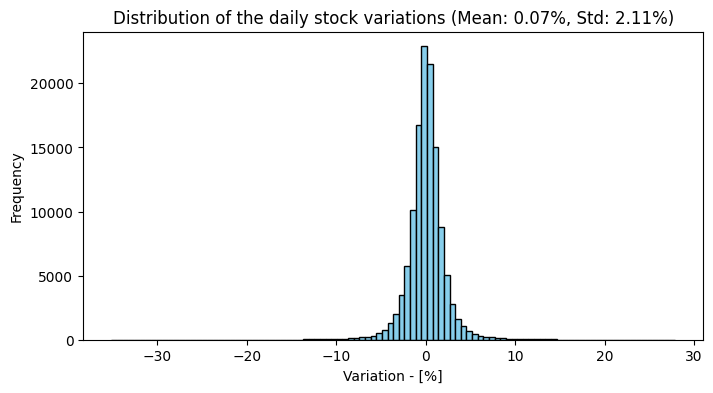

In [8]:
plt.figure(figsize=(8, 4))

plt.hist(values["Variation"], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of the daily stock variations (Mean: {values['Variation'].mean():.2f}%, Std: {values['Variation'].std():.2f}%)")
plt.xlabel("Variation - [%]")
plt.ylabel("Frequency")
plt.show()

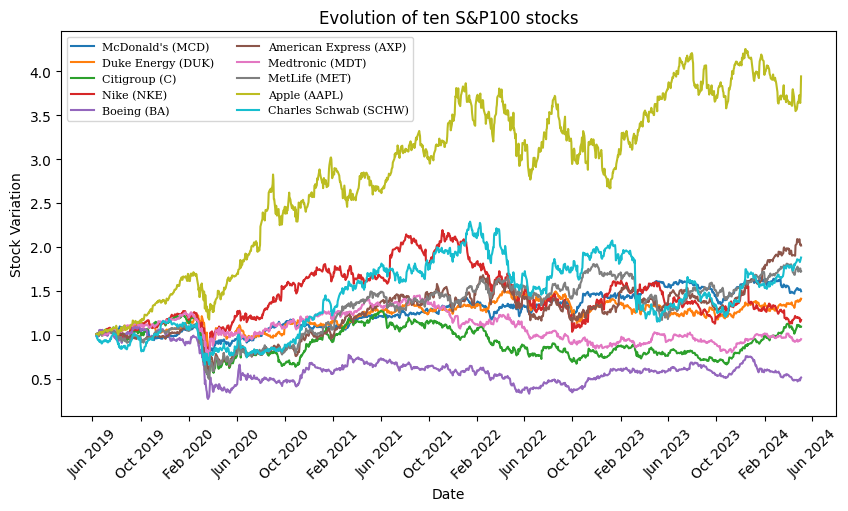

In [28]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumprod(1 + values.loc[stock]["Variation"] / 100), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Variation')
plt.legend(ncol=2, loc="upper left", prop={'size': 8, 'family': 'serif'})
plt.show()

In [9]:
values.to_csv("../data/SP100/raw/values.csv")